In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

plt.style.use("seaborn")

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

## Variational Bayes Regression
Lienar regression model is written as below.

$$
p(y \mid x, w, b, \sigma) = \mathcal N (y \mid wx + b, \sigma)
$$

Where, $w, b$ are regard as random variables, and $\sigma$ is known value $1.0$ (Note: $\sigma$ is regard as hyperparameter in this model.). Therefore, we should set prior each random variables, $p(w), p(b)$.

Then, we can write the joint distribution given x as below.

$$
p(y, w, b \mid x) = p(y\mid x, w, b)p(w)p(b)
$$

And we can get posterior distribution of $w, b$ if we set good behavior prior and likelihood.

$$
p(w, b \mid x, y) = ???
$$

However, posterior of complex model is often not earned. So, we prepare approximate distribution called variational distribution. In this notebook, we use mean field approximate.

$$
q(w)q(b) \simeq p(w, b \mid x, y)
$$



In [20]:
class VariationalBayesModel(tf.Module):
    def __init__(self, optimizer=tf.optimizers.Adam()):
        self.optimizer = optimizer
        
        self.w_prior = tfd.Normal(loc=tf.zeros([]), scale=10*tf.ones([]))
        self.b_prior = tfd.Normal(tf.zeros([]), scale=10*tf.ones([]))
        
        self.qw_loc = tf.Variable(tf.zeros([]), name="qw_loc")
        self.qw_scale = tf.Variable(tf.ones([]), name="qw_scale")
        self.qb_loc = tf.Variable(tf.zeros([]), name="qb_loc")
        self.qb_scale = tf.Variable(tf.ones([]), name="qb_scale")
        
        self.Root = tfd.JointDistributionCoroutine.Root
        
    def joint_distribution(self, x):
        
        def __joint_distribution():
            w = yield self.Root(self.w_prior)
            b = yield self.Root(self.b_prior)
            linear = w * x + b
            y = yield tfd.Independent(
                tfd.Normal(loc=linear, scale=1.0),
                reinterpreted_batch_ndims=1
            )

        return tfd.JointDistributionCoroutine(__joint_distribution)
    
    def variational_distribution(self):
        
        def __variational_distribution():
            w = yield self.Root(
                tfd.Normal(loc=self.qw_loc, scale=tf.exp(self.qw_scale))
            )
            b = yield self.Root(
                tfd.Normal(loc=self.qb_loc, scale=tf.exp(self.qb_scale))
            )
            
        return tfd.JointDistributionCoroutine(__variational_distribution)
    
    def log_joint_probability(self, x, w, b, y):
        joint_prob = self.joint_distribution(x).log_prob([w, b, y])
        return tf.reduce_mean(joint_prob)
    
    def loss(self, x, y):
        qw_sample, qb_sample = self.variational_distribution().sample()
        kl_div = self.w_prior.log_prob(qw_sample) \
               + self.b_prior.log_prob(qb_sample)
        log_joint_prob = self.log_joint_probability(x, qw_sample, qb_sample, y)
        return kl_div - log_joint_prob
    
    def train(self, x, y, print_loss=False):
        with tf.GradientTape() as g:
            loss_value = self.loss(x, y)
        grads = g.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        if print_loss:
            print("loss: ", loss_value.numpy())
    
    def predict(self, x):
        qw_sample, qb_sample = self.variational_distribution().sample()
        joint_dist = self.joint_distribution(x)
        predictive_distribution, samples = joint_dist.sample_distributions(value=[qw_sample, qb_sample, None])
        return predictive_distribution, samples
    
    

In [21]:
model = VariationalBayesModel(tf.optimizers.SGD(1e-1))

In [22]:
model.joint_distribution(tf.random.normal(shape=[100, ])).sample()

(<tf.Tensor: id=297656, shape=(), dtype=float32, numpy=25.574846>,
 <tf.Tensor: id=297679, shape=(), dtype=float32, numpy=-0.40059733>,
 <tf.Tensor: id=297716, shape=(100,), dtype=float32, numpy=
 array([ 10.605002  ,  42.382263  , -35.38325   , -20.01952   ,
         32.275333  , -23.82296   ,   9.019023  ,  43.796455  ,
         20.486147  ,  31.568438  , -13.284929  ,  -6.8204427 ,
          3.5409112 ,   2.613684  ,  20.55182   ,   1.7783319 ,
         63.50772   ,  -8.942026  ,   5.0867586 , -51.859802  ,
        -44.68154   , -20.170816  , -34.138985  ,  37.687256  ,
         13.043158  ,   7.623758  , -10.538601  , -37.133904  ,
         -2.2593338 ,  20.24256   , -11.033534  , -25.206228  ,
         16.361378  ,  -9.707565  , -20.367615  ,   6.202437  ,
        -22.223959  ,  17.702175  ,  19.427143  ,  55.99585   ,
        -16.382975  ,  -6.3969193 , -11.680811  ,  37.42334   ,
         -2.3376083 ,  37.886272  ,  26.496883  ,  -9.470086  ,
         35.233772  ,  11.612275  , 

In [23]:
model.variational_distribution().sample()

(<tf.Tensor: id=297742, shape=(), dtype=float32, numpy=-2.3778858>,
 <tf.Tensor: id=297768, shape=(), dtype=float32, numpy=-2.8499582>)

In [35]:
def toy_data():
    x = np.random.rand(100).reshape(100, 1)
    y = 5*x -3 + 1.0*np.random.randn(100).reshape(100, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

In [36]:
train_x, train_y = toy_data()

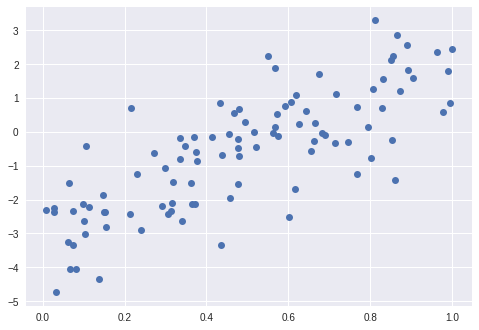

In [37]:
plt.plot(train_x, train_y, "o")

In [38]:
for i in range(1000):
    print_flag = True if (i+1)%100 == 0 else False
    model.train(train_x, train_y, print_flag)

loss:  1.6447945
loss:  1.5636082
loss:  1.5156221
loss:  1.5205631
loss:  1.5116425
loss:  1.510179
loss:  1.5110483
loss:  1.5095196
loss:  1.5092545
loss:  1.5138397


In [39]:
x_test = tf.linspace(-0.5, 1.5, 1000)
dist, _ = model.predict(x_test)

In [40]:
predictive_dist = dist[-1]

In [41]:
sample = predictive_dist.sample()

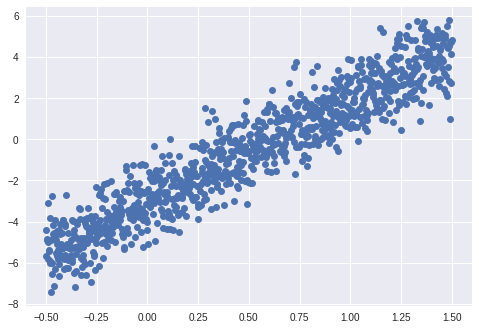

In [42]:
plt.plot(x_test.numpy(), sample.numpy(), "o")

In [43]:
many_samples = predictive_dist.sample(10000)
mean = tf.reduce_mean(many_samples, axis=0)
std = tf.sqrt(tf.reduce_mean((many_samples - mean)**2, axis=0))

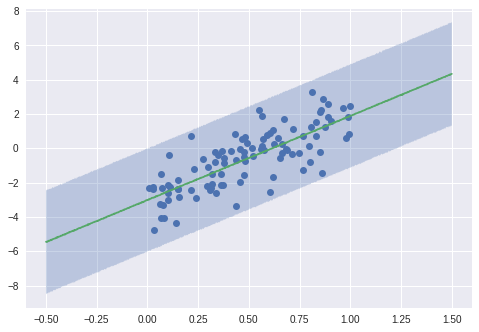

In [46]:
plt.plot(train_x, train_y, "o")
plt.plot(x_test.numpy(), mean.numpy())
plt.fill_between(x_test.numpy(), mean+3*std, mean-3*std, alpha=0.3)